# PMF for Recommender Systems

This is an implementation for Probabilistic Matrix Factorisation. We have made use of a subset of the IMDB dataset for training purposes.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.linalg import orthogonal_procrustes
from sklearn.metrics import mean_squared_error
from helpers_pmf import *

In [165]:
mu = 0.0 
sigma_u = 0.5#1.0
sigma_v = 0.5#1.0
sigma = 0.1 #[0, 0.2, 0.4, 0.6, 0.8, 1] 
parameters = {}
d_dims = 2 
# n_users = 10
# n_movies = 300 
# alpha = 1
# alpha_vals = [1, 3, 10, 30, 100] 
# M_vals = [n_movies*alpha for alpha in alpha_vals]
# k_best = 10 
# nb_iter = 50 

__generate__ matrices U, V and R from Gauss. distributions

In [59]:
def generate_U_V_R(mu, lambda_U, lambda_V, sigma, n_users, n_movies):
    U = np.random.normal(mu, lambda_U, size=(d_dims,n_users))
    V = np.random.normal(mu, lambda_V, size=(d_dims,n_movies))
    noise = np.random.normal(mu, sigma, size=(n_users,n_movies)) 
    R = np.matmul(U.T,V) +noise
    
    return U, V, R

We will now initialise our parameters. First the $V$ matrix can be initialised randomly using the following distribution:

\begin{equation}
\large
V \sim \mathcal N\left(0, \frac {1} {\lambda_V}\right)
\end{equation}

Let's remember that:

\begin{equation}
\large
U \in \mathbb R^{D\times N}, \qquad V \in \mathbb R^{D\times M}
\end{equation}

Where $N$ is __n_users__, $M$ is __n_movies__ and $D$ is __n_dims__.

In [60]:
def initialize_parameters(lambda_U, lambda_V, mu, sigma, n_users, n_movies):    
    U, V, R = generate_U_V_R(mu, 1.0 /lambda_U, 1.0 /lambda_V, sigma, n_users, n_movies)  
    #U_init = np.zeros((d_dims, n_users), dtype=np.float64)
    U_init = np.random.normal(mu, 1.0 / lambda_U, (d_dims, n_users))
    #U_init = np.random.normal(mu, 0.01, (d_dims, n_users))
    V_init = np.random.normal(mu, 1.0 / lambda_V, (d_dims, n_movies))
    
    # applyall = np.vectorize(condition)    #scale R values within range 1-5
    # R_res = applyall(R)
    
    parameters['U'] = U
    parameters['V'] = V
    parameters['R'] = R#R_res
    parameters['U_result'] = U_init
    parameters['V_result'] = V_init
    parameters['lambda_U'] = lambda_U
    parameters['lambda_V'] = lambda_V

create __ratings__ dataframe and append rating matrix

In [61]:
def create_rating_df(n_users, n_movies):   
    initialize_parameters(sigma_u/sigma, sigma_v/sigma, mu, sigma, n_users, n_movies)
    
    df = pd.DataFrame(columns=['userID', 'movieID'])
    df['userID'] = np.repeat(np.arange(1, n_users+1, 1), n_movies)
    df['movieID'] = np.tile(np.arange(1, n_movies+1, 1), n_users) #np.tile
    
    R = parameters['R']
    df['rating'] = R.reshape(n_users*n_movies)
    
    return df 

__split__ the dataset into train and test sets

In [62]:
def split_train_test(df, train_size=0.75):
    
    df_copy = df.copy()
    train_set = df_copy.sample(frac=train_size, random_state=0)
    test_set = df_copy.drop(train_set.index)
    
    return train_set, test_set
     

Let's now implement the function that updates U and V. The elements of both matrices can be updated using the following expressions:

\begin{equation}
\large
U_i=\left[\left(V_jV_j^T\right)_{j\in\Omega_{U_i}}+\lambda_UI\right]^{-1}\left(R_{ij}V_j^T\right)_{j\in\Omega_{U_i}}
\end{equation}

\begin{equation}
\large
V_j=\left[\left(U_iU_i^T\right)_{i\in\Omega_{V_j}}+\lambda_VI\right]^{-1}\left(R_{ij}U_i^T\right)_{i\in\Omega_{V_j}}
\end{equation}

In [63]:
def update_parameters(n_users, n_movies):
    U = parameters['U_result']
    V = parameters['V_result']
    R = parameters['R']
    lambda_U = parameters['lambda_U']
    lambda_V = parameters['lambda_V']

    for i in range(n_users):
        # V_j = V[:, R[i, :] > 0]
        # U[:, i] = np.dot(np.linalg.inv(np.dot(V_j, V_j.T) + lambda_U * np.identity(d_dims)), np.dot(R[i, R[i, :] > 0], V_j.T))
        RV = R[i] @ V.T
        #print('RV:',RV.shape)
        #print('V.V^T:',np.dot(V,V.T).shape)

        Vinv = np.linalg.inv(np.dot(V,V.T) + lambda_U * np.identity(d_dims))#d_dims
        U[:, i] =  Vinv @ RV 
        
    for j in range(n_movies):
        # U_i = U[:, R[:, j] > 0]
        # V[:, j] = np.dot(np.linalg.inv(np.dot(U_i, U_i.T) + lambda_V * np.identity(d_dims)), np.dot(R[R[:, j] > 0, j], U_i.T))
        RU = R[:, j] @ U.T
        Uinv = np.linalg.inv(np.dot(U, U.T) + lambda_V * np.identity(d_dims))
        V[:, j] = Uinv @ RU
 
    parameters['U_result'] = U
    parameters['V_result'] = V

Now let's implement the __Log-a posteriori__:

\begin{equation}
\large
L=-\frac 1 2 \left(\sum_{i=1}^N\sum_{j=1}^M(R_{ij}-U_i^TV_j)_{(i,j) \in \Omega_{R_{ij}}}^2+\lambda_U\sum_{i=1}^N\|U_i\|_{Fro}^2+\lambda_V\sum_{j=1}^M\|V_j\|_{Fro}^2\right)
\end{equation}

In [64]:
def log_a_posteriori():
    lambda_U = parameters['lambda_U']
    lambda_V = parameters['lambda_V']
    U_result = parameters['U_result']
    V_result = parameters['V_result']
    R = parameters['R']
    UV = np.dot(U_result.T, V_result)
    R_UV = (R[R > 0] - UV[R > 0])
    
    return -0.5 * (np.sum(np.dot(R_UV, R_UV.T)) + lambda_U * np.sum(np.dot(U_result, U_result.T)) + \
                   lambda_V * np.sum(np.dot(V_result, V_result.T)))


For the purposes of __scaling__, we need the maximum and minimum rating values.

In [65]:
def update_max_min_ratings():
    U = parameters['U_result']
    V = parameters['V_result']

    R = U.T @ V
    min_rating = np.min(R)
    max_rating = np.max(R)

    parameters['min_rating'] = min_rating
    parameters['max_rating'] = max_rating

The __predict__ function allows us to predict the rating value given the __user_id__ and the __movie_id__ parameters. The value has been scaled within the range 0-5

In [66]:
def predict(user_id, movie_id):
    U = parameters['U_result']
    V = parameters['V_result']
    #print('U.T : ',U[:,user_id-1])
    r_ij = U[:, user_id-1].T.reshape(1, -1) @ V[:, movie_id-1].reshape(-1, 1) #user_id-1 shouled be changed
    max_rating = parameters['max_rating']
    min_rating = parameters['min_rating']

    return 0 if max_rating == min_rating else ((r_ij[0][0] - min_rating) / (max_rating - min_rating)) * 5.0

We implement both the __Frobenius__ and __orthogonal Procrustes__ norms

In [67]:
def frob(X, Y, N):
    return np.linalg.norm(X - Y, 'fro')/np.sqrt(N)

In [141]:
#add more comments for each cell, provide links/resources 
def orth_procrustes(X, Y, len_X):
    R, scale = orthogonal_procrustes(X, Y)
    rss = np.linalg.norm(X @ R - Y, 'fro')/np.sqrt(len_X)
    
    return rss

The __compare_results__ function will calculate the Frobenius/ Orthogonal Procrustes __norm difference__ of the resulting U and V matrices with the initial ones

In [186]:
def compare_results(n_users, n_movies):
    #U = parameters['U']
    #V = parameters['V']
    R = parameters['R']

    U_result = parameters['U_result']
    V_result = parameters['V_result']    
    
    #diff_norm_U = orth_procrustes(U, U_result, n_users)     #frob(U, U_result, n_users)#  
    #diff_norm_V = orth_procrustes(V, V_result, n_movies) #frob(V, V_result, n_movies)#     
    diff_norm_R = frob(R, U_result.T @ V_result , n_movies*n_users) #orth_procrustes(R, U_result.T @ V_result , n_movies)#
    return diff_norm_R #diff_norm_U, diff_norm_V


The __evaluate__ function will calculate the __RMSE__ of the model given a dataset (train or test).

In [187]:
def evaluate(dataset):
    ground_truths = []
    predictions = []
    
    for index, row in dataset.iterrows():    
        ground_truths.append(row.loc['rating'])
        print(index,row.loc['userID'])
        predictions.append(predict(row.loc['userID'], row.loc['movieID'])) 

    return mean_squared_error(ground_truths, predictions, squared=False)

The __train__ function implements the code necessary for training the model as well as recording the __RMSE__ values on the training and testing sets.

In [188]:
def train(n_epochs, train_set, test_set, n_users, n_movies):
    initialize_parameters(1.0 / sigma_u, 1.0 / sigma_v, mu, sigma, n_users, n_movies)
    log_aps = []
    rmse_train = []
    rmse_test = []

    update_max_min_ratings()
    #rmse_train.append(evaluate(train_set))
    #rmse_test.append(evaluate(test_set))
    
    for k in range(n_epochs):
        update_parameters(n_users, n_movies)
        log_ap = log_a_posteriori()
        log_aps.append(log_ap)

        if (k + 1) % 25 == 0: #10
            update_max_min_ratings()

            #rmse_train.append(evaluate(train_set))
            #rmse_test.append(evaluate(test_set))
            #print('Log p a-posteriori at iteration', k + 1, ':', log_ap)

    update_max_min_ratings()
    #diff_norm_U, diff_norm_V = compare_results(n_users, n_movies)
    diff_norm_R = compare_results(n_users, n_movies)

    return log_aps, rmse_train, rmse_test, diff_norm_R #diff_norm_U, diff_norm_V

Let's train our model!

In [189]:
def avg_results(N_val, M_val, n_epochs, nb_iter):
        avg_U = 0
        avg_V = 0
        avg_R = 0
        for i in range(nb_iter):

            df_ratings = create_rating_df(N_val, M_val)
            train_set, test_set = split_train_test(df_ratings, train_size=0.8)
            #_, _, _, diff_U, diff_V = train(n_epochs, train_set, test_set, N_val, M_val)  
            _, _, _, diff_R = train(n_epochs, train_set, test_set, N_val, M_val)   
 
            #avg_U += diff_U
            #avg_V += diff_V
            avg_R += diff_R
            
        #avg_U /= nb_iter
        #avg_V /= nb_iter
        avg_R /= nb_iter
        return avg_R #avg_U, avg_V

In [194]:
N_vals = [10, 20, 30, 40, 50]#, 100]
M_vals = [10, 20, 30, 40, 50]
n_epochs = 100
nb_iter = 100
data = []
for i in range(len(N_vals)):
    for j in range(len(M_vals)):
        print(f'i,j:{i},{j}') # 
        #avg_U, avg_V = avg_results(N_vals[i], M_vals[j], n_epochs, nb_iter)
        avg_R = avg_results(N_vals[i], M_vals[j], n_epochs, nb_iter)
        #row= [N_vals[i], M_vals[j], avg_U, avg_V]
        row= [N_vals[i], M_vals[j], avg_R]
        print(row) # to check progress


        data.append(row)       

i,j:0,0
[10, 10, 0.2678027413012763]
i,j:0,1
[10, 20, 0.21443147460847062]
i,j:0,2
[10, 30, 0.1842378084916305]
i,j:0,3
[10, 40, 0.16598187329990274]
i,j:0,4
[10, 50, 0.15372404496748046]
i,j:1,0
[20, 10, 0.21597461833507384]
i,j:1,1
[20, 20, 0.16728729804919149]
i,j:1,2
[20, 30, 0.14750375158615736]
i,j:1,3
[20, 40, 0.13622380815654553]
i,j:1,4
[20, 50, 0.129012301682241]
i,j:2,0
[30, 10, 0.18452208359025804]
i,j:2,1
[30, 20, 0.14750240128925046]
i,j:2,2
[30, 30, 0.13289405873654472]
i,j:2,3
[30, 40, 0.12464216570935249]
i,j:2,4
[30, 50, 0.11946817252083829]
i,j:3,0
[40, 10, 0.16602848548798427]
i,j:3,1
[40, 20, 0.13623056105624978]
i,j:3,2
[40, 30, 0.12486013070633889]
i,j:3,3
[40, 40, 0.11850549950954406]
i,j:3,4
[40, 50, 0.11443307294556193]
i,j:4,0
[50, 10, 0.15378929037167136]
i,j:4,1
[50, 20, 0.1290608349237441]
i,j:4,2
[50, 30, 0.1193578794658632]
i,j:4,3
[50, 40, 0.11463149799768285]
i,j:4,4
[50, 50, 0.11146390683432988]


In [195]:
data[:50]

[[10, 10, 0.2678027413012763],
 [10, 20, 0.21443147460847062],
 [10, 30, 0.1842378084916305],
 [10, 40, 0.16598187329990274],
 [10, 50, 0.15372404496748046],
 [20, 10, 0.21597461833507384],
 [20, 20, 0.16728729804919149],
 [20, 30, 0.14750375158615736],
 [20, 40, 0.13622380815654553],
 [20, 50, 0.129012301682241],
 [30, 10, 0.18452208359025804],
 [30, 20, 0.14750240128925046],
 [30, 30, 0.13289405873654472],
 [30, 40, 0.12464216570935249],
 [30, 50, 0.11946817252083829],
 [40, 10, 0.16602848548798427],
 [40, 20, 0.13623056105624978],
 [40, 30, 0.12486013070633889],
 [40, 40, 0.11850549950954406],
 [40, 50, 0.11443307294556193],
 [50, 10, 0.15378929037167136],
 [50, 20, 0.1290608349237441],
 [50, 30, 0.1193578794658632],
 [50, 40, 0.11463149799768285],
 [50, 50, 0.11146390683432988]]

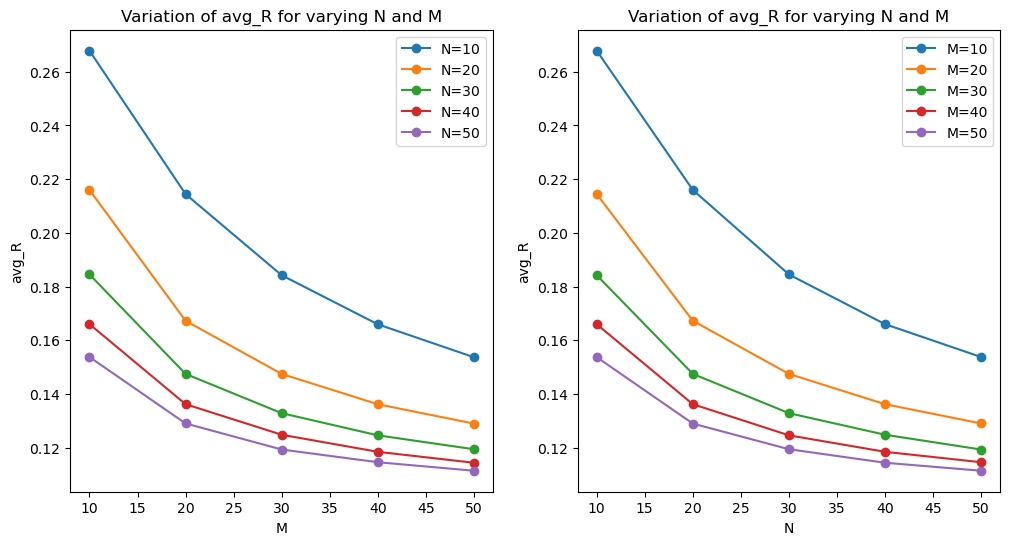

In [197]:
df = pd.DataFrame(data, columns = ['N', 'M', 'avg_R'])
#df.to_csv('results_optimization.csv')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
# plot as a function of M for avg_U and as a function of N fro avg_V

for n in df['N'].unique():
    df_m = df[df['N'] == n]
    ax1.plot(df_m['M'], df_m['avg_R'], marker='o', label=f'N={n}')

for m in df['M'].unique():
    df_n = df[df['M'] == m]
    ax2.plot(df_n['N'], df_n['avg_R'], marker='o', label=f'M={m}')

ax1.set_xlabel('M')
ax1.set_ylabel('avg_R')
ax1.set_title('Variation of avg_R for varying N and M')
ax1.legend()

ax2.set_xlabel('N')
ax2.set_ylabel('avg_R')
ax2.set_title('Variation of avg_R for varying N and M')
ax2.legend()


plt.show()

In [ ]:
fig.savefig('avg_PMF_R.png')

In [ ]:
df = pd.DataFrame(data, columns = ['N', 'M', 'avg_U', 'avg_V'])
#df.to_csv('results_optimization.csv')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
# plot as a function of M for avg_U and as a function of N fro avg_V

for n in df['N'].unique():
    df_m = df[df['N'] == n]
    ax1.plot(df_m['M'], df_m['avg_U'], marker='o', label=f'N={n}')
for m in df['M'].unique():
    df_n = df[df['M'] == m]
    ax2.plot(df_n['N'], df_n['avg_V'], marker='o', label=f'M={m}')

ax1.set_xlabel('M')
ax1.set_ylabel('avg_U')
ax1.set_title('Variation of avg_U for varying N and M')
ax1.legend()

ax2.set_xlabel('N')
ax2.set_ylabel('avg_V')
ax2.set_title('Variation of avg_V for varying N and M')
ax2.legend()

plt.show()

In [52]:
fig.savefig('avg_PMF_U_V.png')

1.171911073692837


Now let's take a look at some graphs

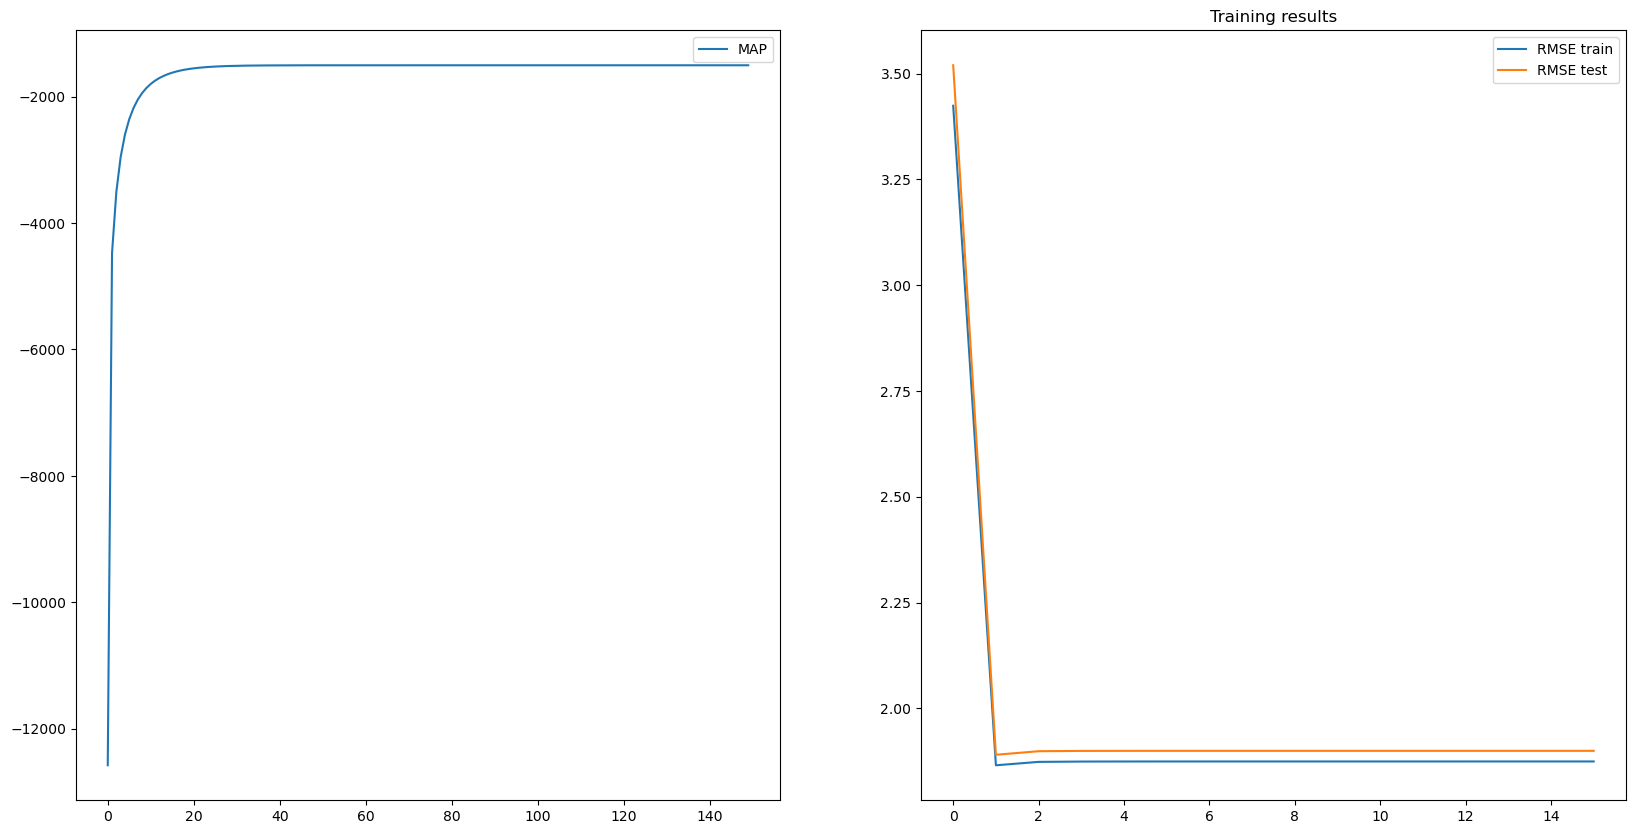

[3.424057047811363, 1.8653639819358674, 1.8733847318440469, 1.8741502565702288, 1.8743030514689587, 1.8743507621417954, 1.8743692960378406, 1.8743770771520538, 1.8743804264216484, 1.8743818798824974, 1.8743825124089604, 1.8743827879572854, 1.8743829080411996, 1.874382960381665, 1.8743829831964598, 1.8743829931414935]


In [19]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
plt.title('Training results')
ax1.plot(np.arange(len(log_ps)), log_ps, label='MAP')
ax1.legend()

ax2.plot(np.arange(len(rmse_train)), rmse_train, label='RMSE train')
ax2.plot(np.arange(len(rmse_test)), rmse_test, label='RMSE test')
ax2.legend()
plt.show()
print(rmse_train)

Let's now evaluate our model on both the training and testing sets.

In [20]:
print('RMSE of training set:', evaluate(train_set))
print('RMSE of testing set:', evaluate(test_set))

RMSE of training set: 1.8743829931414935
RMSE of testing set: 1.8995113795164769


Now we will pick a user from the database and look at his/her preferences.

In [21]:
user_id = 45
df_join[df_join['userId'] == user_id].sort_values(by=['rating'], ascending=False).head(10)

NameError: name 'df_join' is not defined

Let's look at the least preferred items.

In [ ]:
df_join[df_join['userId'] == user_id].sort_values(by=['rating']).head(10)

Let's now look at the most likely preferences of the selected user.

In [ ]:
predictions = np.zeros((n_movies, 1))
movie_to_column_items = np.array(list(movie_to_column.items()))
df_result = pd.DataFrame(columns=['UserID', 'MovieID', 'Movie', 'Genres', 'Prediction'])

for i, movie in enumerate(movie_to_column_items):
    predictions[i] = predict(user_id, movie[0])
    
indices = np.argsort(-predictions, axis=0)

for j in range(10):
    movie_id = int(movie_to_column_items[np.where(movie_to_column_items[:, 1] == indices[j])][0][0])
    df_row = pd.DataFrame({
        'UserID': user_id,
        'MovieID': movie_id,
        'Movie': df_movies[df_movies['movieId'] == movie_id].iloc[0]['title'],
        'Genres': df_movies[df_movies['movieId'] == movie_id].iloc[0]['genres'],
        'Prediction': predictions[indices[j]][0][0]
    }, index=[j])
    df_result = df_result.append(df_row, sort=False)
    
df_result

Now the predictions for least preferred items.

In [ ]:
df_result = pd.DataFrame(columns=['UserID', 'MovieID', 'Movie', 'Genres', 'Prediction'])
indices = np.argsort(predictions, axis=0)

for j in range(10):
    movie_id = int(movie_to_column_items[np.where(movie_to_column_items[:, 1] == indices[j])][0][0])
    df_row = pd.DataFrame({
        'UserID': user_id,
        'MovieID': movie_id,
        'Movie': df_movies[df_movies['movieId'] == movie_id].iloc[0]['title'],
        'Genres': df_movies[df_movies['movieId'] == movie_id].iloc[0]['genres'],
        'Prediction': predictions[indices[j]][0][0]
    }, index=[j])
    df_result = df_result.append(df_row, sort=False)
    
df_result

I hope you enjoyed this exercise. Something you can also try on your own is to implement gradient descent instead of MAP-estimation like I did here. Let me know about any comments you may have.